In [1]:
import pandas as pd
import numpy as np
import acessos as ac
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
query = '''

select * from customer_sandbox_zone.segmentacao_digital_credito_flavia

'''

In [8]:
df = ac.df_athena('flavia-costa', query)

In [4]:
df.head()

,cpf,tempo_relacionamento,ds_risk_type,gender,nr_declared_income,ds_region,ds_occupation,nm_current_os,ds_city_size,flag_autonomo,...,trans_recorrente,trans_mobilidade_app,trans_delivery,trans_recarga_geral,trans_streaming,trans_rede_social,trans_games,trans_cripto,ds_cluster_sociodemographic,ordem
0,08908967559,1794.0,1. Sem Informacao,FEMALE,0.01,Nordeste,AUTÔNOMO,None,pequeno,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",1024
1,06489947595,1461.0,2. Alto Risco,FEMALE,0.01,Nordeste,ESTUDANTE,ios,pequeno,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",1025
2,70590237470,1393.0,2. Alto Risco,FEMALE,0.01,Nordeste,ATENDENTE,android,pequeno,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",1026
3,08648545366,608.0,4. Baixo Risco,FEMALE,300.00,Nordeste,Empregado(a) Doméstico(a),ios,pequeno,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",1027
4,10318328585,477.0,3. Medio Risco,FEMALE,9000.00,Nordeste,Autônomo(a),android,pequeno,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"10 - Mulher, Solteira, Até 24 anos, cidade Peq...",1028


In [9]:
for column in df.columns:
  if df[column].dtype == 'object':
    df[column].fillna(df[column].mode()[0], inplace = True)
  elif df[column].dtype != 'object':
    df[column].fillna(df[column].median(), inplace = True)

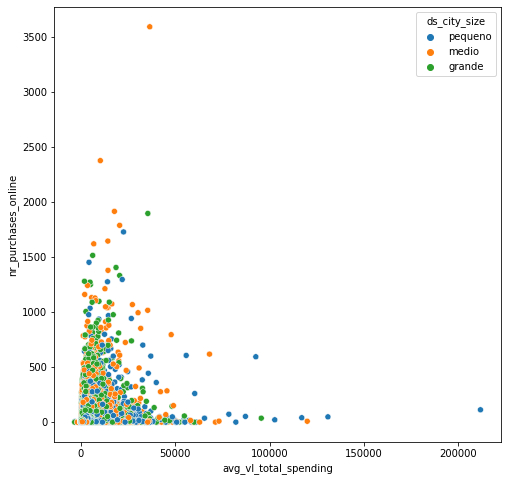

In [10]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x="avg_vl_total_spending", y="nr_purchases_online", hue="ds_city_size")
plt.show()

In [5]:
df.columns

Index(['cpf', 'tempo_relacionamento', 'ds_risk_type', 'gender',
       'nr_declared_income', 'ds_region', 'ds_occupation', 'nm_current_os',
       'ds_city_size', 'flag_autonomo', 'nr_trans_pix',
       'nr_antecipacao_fatura', 'flag_bolso', 'nr_purchases_virtual',
       'avg_vl_total_spending', 'nr_purchases_online',
       'nr_purchases_contactless', 'nr_recarga_credito', 'nr_acessos',
       'pc_acessos_lojawill', 'nr_pagamentos_conta',
       'nr_pagamentos_conta_credito', 'trans_recorrente',
       'trans_mobilidade_app', 'trans_delivery', 'trans_recarga_geral',
       'trans_streaming', 'trans_rede_social', 'trans_games', 'trans_cripto',
       'ds_cluster_sociodemographic', 'ordem'],
      dtype='object')

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportions_ztest
from sklearn.decomposition import PCA


features_cluster = ['nr_trans_pix',
       'nr_antecipacao_fatura', 'flag_bolso', 'nr_purchases_virtual',
       'avg_vl_total_spending', 'nr_purchases_online',
       'nr_purchases_contactless', 'nr_recarga_credito', 'nr_acessos',
       'pc_acessos_lojawill', 'nr_pagamentos_conta',
       'nr_pagamentos_conta_credito', 'trans_recorrente',
       'trans_mobilidade_app', 'trans_delivery', 'trans_recarga_geral',
       'trans_streaming', 'trans_rede_social', 'trans_games', 'trans_cripto']

base_cluster = df[features_cluster]


In [12]:
pca = PCA(n_components=0.95) #Explicar 95% da variância
pca.fit(base_cluster)
base_cluster_pca = pca.transform(base_cluster)

print(base_cluster_pca.shape[1])

1


In [13]:
pca = PCA(n_components=2)
pca.fit(base_cluster)
base_cluster_pca = pca.transform(base_cluster)


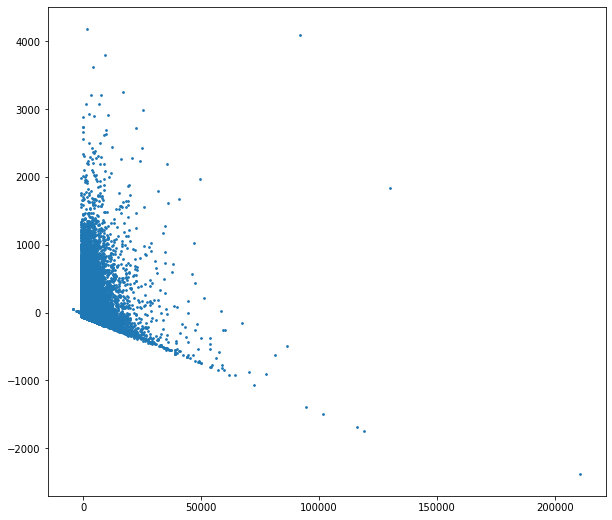

In [14]:
plt.figure(figsize=(10,9))
plt.scatter(base_cluster_pca[:, 0], base_cluster_pca[:, 1], s=3, cmap='Spectral')
plt.show()

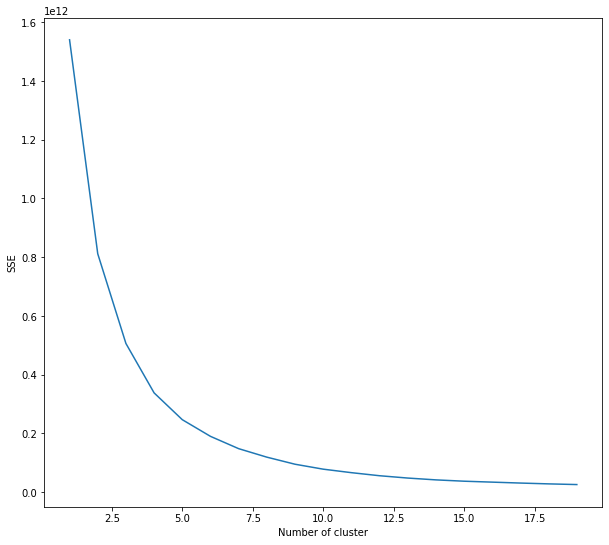

In [15]:
#AVALIANDO MELHOR NR DE CLUSTERS
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(base_cluster)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure(figsize=(10,9))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [19]:
#DEFININDO NR DE CLUSTERS
k = 30

#NORMALIZAÇÃO
scaler = StandardScaler()
scaler_model = scaler.fit(base_cluster)
data_input_scaled = scaler_model.transform(base_cluster)


#ALGORITMO
kmeans = KMeans(n_clusters = k, random_state=0).fit(data_input_scaled)


cluster = kmeans.predict(data_input_scaled)
base_cluster['cluster'] = cluster
df['cluster'] = cluster


print("---------------VOLUMETRIA ------------------")
print(df['cluster'].value_counts())


---------------VOLUMETRIA ------------------
0     477742
2      90358
8      16691
26     12211
12      8834
13      6334
5       6097
4       6039
17      5693
19      3800
16      3375
7       2457
21       860
25       824
22       773
3        662
23       410
29       324
1        268
18       238
15       213
14        96
24        81
27        39
28        28
20        17
9          9
10         8
6          3
11         1
Name: cluster, dtype: int64


/tmp/ipykernel_1215423/2268520669.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_cluster['cluster'] = cluster


In [20]:
print("---------------VOLUMETRIA ------------------")
print(df['cluster'].value_counts(normalize = True))

---------------VOLUMETRIA ------------------
0     0.741277
2     0.140202
8     0.025898
26    0.018947
12    0.013707
13    0.009828
5     0.009460
4     0.009370
17    0.008833
19    0.005896
16    0.005237
7     0.003812
21    0.001334
25    0.001279
22    0.001199
3     0.001027
23    0.000636
29    0.000503
1     0.000416
18    0.000369
15    0.000330
14    0.000149
24    0.000126
27    0.000061
28    0.000043
20    0.000026
9     0.000014
10    0.000012
6     0.000005
11    0.000002
Name: cluster, dtype: float64


In [22]:
print("---------------SILHOUETTE SCORE ------------")
#print(silhouette_score(base_cluster[features_cluster], base_cluster['cluster']))

---------------SILHOUETTE SCORE ------------


KeyboardInterrupt: 

In [24]:
x_train, x_test, y_train, y_test = train_test_split(base_cluster[features_cluster]
                                                    , base_cluster['cluster']
                                                    , random_state=42, test_size=0.20)
arvores = [50, 100, 300, 400]
accuracy_array = []

for i in arvores:
  rf = RandomForestClassifier(n_estimators=i)
  rf.fit(x_train, y_train)
  y_predicted_rf = rf.predict(x_test)
  accuracy_rf = accuracy_score(y_test, y_predicted_rf).round(4)
  accuracy_array.append(accuracy_rf)
  print(i)
rf_estimators = pd.DataFrame(list(zip(arvores, accuracy_array)), columns =['arvores', 'acuracia'])
print("---------------ACURACCY CLASSIFICATION ------------")
rf_estimators['acuracia'].max()



50
100


: 

In [ ]:
print("---------------IMPORTANCIA DAS FEATURES - O QUE MAIS PESOU NA CONSTRUÇÃO DOS GRUPOS? ------------")
best_rf = RandomForestClassifier(n_estimators= rf_estimators['arvores'][rf_estimators['acuracia'].idxmax()])
best_rf.fit(x_train, y_train)
importance_df = pd.DataFrame(best_rf.feature_importances_, columns = ['importancia'], index = features_cluster)
importance_df.sort_values(by='importancia', ascending=False).head(15).plot.bar(figsize=(20,5))


In [ ]:
features_importantes = importance_df.sort_values(by='importancia', ascending=False).head(20).index

In [ ]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

print("---------------MEDIAS POR CLUSTER ------------")
cl_col = ['cluster']
totalfeat = features_cluster + cl_col
df[totalfeat].groupby('cluster').mean().style.apply(highlight_max, subset=[features_cluster])


---------------MEDIAS POR CLUSTER ------------


,nr_trans_pix,nr_antecipacao_fatura,flag_bolso,nr_purchases_virtual,avg_vl_total_spending,nr_purchases_online,nr_purchases_contactless,nr_recarga_credito,nr_acessos,pc_acessos_lojawill,nr_pagamentos_conta,nr_pagamentos_conta_credito,trans_recorrente,trans_mobilidade_app,trans_delivery,trans_recarga_geral,trans_streaming,trans_rede_social,trans_games,trans_cripto
cluster,,,,,,,,,,,,,,,,,,,,
0,6.845858,0.051697,0.000000,0.441090,749.574682,3.160074,1.852079,0.000069,48.908057,0.003776,0.176156,0.002455,0.493423,0.159230,0.071798,0.009509,0.139209,0.002016,0.015856,0.000015
1,36.649254,1.276119,0.055970,72.522388,4444.621734,206.141791,76.716418,0.000000,272.373134,0.008179,3.011194,0.167910,81.156716,41.417910,128.891791,0.884328,15.570896,0.059701,0.652985,0.000000
2,23.878937,0.185661,0.000000,6.174107,1363.623291,15.535016,19.969056,0.000421,103.338852,0.012054,1.414319,0.018515,2.745446,2.806337,0.993504,0.127460,1.081221,0.026373,0.232840,0.000044
3,34.839879,2.422961,0.013595,0.951662,4457.027654,341.625378,11.193353,0.000000,103.376133,0.000756,0.404834,0.004532,282.703927,173.229607,12.725076,0.616314,15.409366,0.064955,0.563444,0.000000
4,81.471270,0.009604,0.043219,7.451399,2471.118910,19.936248,31.008611,0.000000,503.218082,0.012739,8.894188,0.001821,0.156648,1.667329,0.535022,0.087928,1.690346,0.022520,0.187283,0.000000
5,7.143677,0.000000,0.007217,2.696080,1052.958339,4.309989,4.328030,0.000164,25.458914,0.214310,0.745777,0.001312,0.021978,0.396753,0.252419,0.024930,0.137609,0.010661,0.066918,0.000164
6,4.000000,0.000000,0.000000,17.333333,3375.246944,17.666667,14.000000,0.000000,48.666667,0.039048,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.333333
7,64.234025,0.000000,0.167684,4.973545,1101.833468,13.346357,25.846561,0.000000,196.540090,0.008221,9.324379,2.774522,0.000000,1.867725,0.562475,0.088319,1.824176,0.029711,0.121286,0.000000
8,27.966808,0.000000,1.000000,4.561081,820.688158,10.320053,15.634953,0.000000,107.352645,0.011835,1.604218,0.065305,0.007190,1.999161,0.503445,0.072075,1.158409,0.016416,0.154634,0.000000


---------------MEDIAS POR CLUSTER GRÁFICO ------------


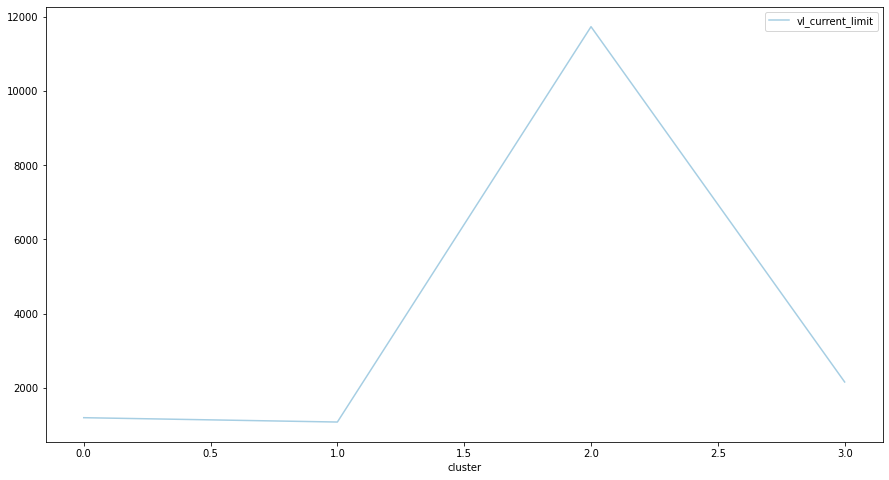

In [54]:
print("---------------MEDIAS POR CLUSTER GRÁFICO ------------")
plt.figure(figsize=(15,8))
sns.lineplot(data = df[['vl_current_limit', 'cluster']].groupby('cluster').mean(), palette = 'Paired')
plt.show()

In [58]:
df[totalfeat].groupby('cluster').median()

,vl_renda_declarada,vl_current_limit,vl_pix_cash_out_credit,nr_trans_pix,nr_trans_ted,nr_ted_willers
cluster,,,,,,
0,4.514367e+03,1195.802722,35.600329,13.426241,0.202633,0.000100
1,8.090687e+07,1078.800000,93.701600,24.400000,0.306667,0.000000
2,1.813244e+03,11736.109348,59.057347,8.432866,0.487830,0.006674
3,3.040946e+03,2158.311798,675.060575,92.239403,4.561043,0.040937


In [57]:
pd.crosstab(df.cluster, df.ds_status, normalize = 'index')

ds_status,a. propensos,b. prospects,c. pouco_propensos,d. nao_propensos
cluster,,,,
0,0.015388,0.011253,0.031000,0.942360
1,0.013333,0.026667,0.053333,0.906667
2,0.096223,0.079259,0.106488,0.718030
3,0.077889,0.039428,0.097995,0.784688
